In [1]:
# import required libraries
import requests
import json
import pandas as pd
import pprint
from pandas import json_normalize
import seaborn as sns
sns.set(palette='deep')

import matplotlib.pyplot as plt

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [2]:
# creating a dictionary we will use to assign a number to each day of the week
day_dict = {"Mo":"1","Tu":"2","We":"3","Th":"4","Fr":"5","Sa":"6","Su":"7"}
# Creating the reverse dictionary, used to output the name of the graph from numerical input representing a day range
rev_day_dict = {"1":"Monday","2":"Tuesday","3":"Wednesday","4":"Thursday","5":"Friday","6":"Saturday","7":"Sunday"}

In [3]:
# A function that returns a string for the day range in the format '[start_day] – [end_day]' for use in the graph title
# unless the start day and end day are the same, in which case that single day is used
def get_range(start_day, end_day):
    if start_day == end_day:
        return rev_day_dict.get(str(start_day))
    else:
        return rev_day_dict.get(str(start_day)) + "-" + rev_day_dict.get(str(end_day))


In [4]:
# A function that takes a list of bus stop names, and creates a dictionary where they keys are
# the stop names, and the values are the names of the buses that stop there
def make_stop_dict(stop_code_list):
    stop_dict = {}
    for stop in stop_code_list:
        stopURL = "https://api.tfl.gov.uk/StopPoint/" + stop
        stopR = requests.get(stopURL)
        stopJ = json.loads(stopR.text)
        for i in stopJ['lineGroup']:
            try:
                if i['naptanIdReference'] == stop:
                    dict_key = i['naptanIdReference']
                    dict_list = i['lineIdentifier']
                    stop_dict[dict_key] = dict_list
            # A KeyError occurs when there is a non-bus stop on the list, which has no naptanIdReference value
            except KeyError:
                continue
    return(stop_dict)

In [5]:
# The main function that pulls the data from TfL's API and graphs it
def get_bus(stop_id_list, title = 'default', start_day = 1, end_day = 7):

    stop_dict = make_stop_dict(stop_id_list)
    
    # create an empty list to hold the data rows
    all_data = []
    
    # create the API timetable URL for each bus for each stop in the dictionary
    for stop_id in stop_dict:
        for bus in stop_dict[stop_id]:
            URL = "https://api.tfl.gov.uk/Line/" + bus + "/Timetable/" + stop_id
            R = requests.get(URL)
            J = json.loads(R.text)
      
            try:
                for route in J["timetable"]["routes"]:
                    for schedule in route["schedules"]:
                                
                        for journey in schedule["knownJourneys"]:
                            journeyrow = []
                            journeyrow.append(stop_id)
                            journeyrow.append(bus)
                            journeyrow.append(schedule["name"])
                            journeyrow.append(journey["hour"])#.zfill(2))
                            journeyrow.append(journey["minute"])#.zfill(2))
                            all_data.append(journeyrow)
            # A KeyError occurs when a stop-bus pair is the last stop on the line - no 'timetable' key exists because passengers cannot embark
            except KeyError:
                print(f'No timetable found for bus {bus} at stop {stop_id}')

    df = pd.DataFrame(columns=['stop','bus','dayName','hour','minute'], data=all_data)

    # creating a new column 'dayNum', filling it with the first two 
    # letters of every day name, and then replacing those letters with a 
    # number as per the dictionary
    df['dayNum'] = df['dayName'].str[:2]
    df.replace({'dayNum':day_dict},inplace=True)

    # sorting the entries so that the days are in order
    df.sort_values(by=['stop','bus','dayNum','hour','minute'], inplace=True)
    # resetting the index
    df.reset_index(drop=True, inplace=True)
    # converting the dayNum to int
    df['dayNum'] = df['dayNum'].astype(int)

    # creates a tuple containing all days of the week to check against
    all_days = (1,2,3,4,5,6,7)
    
    missing_days_df = pd.DataFrame()
    
    # for each bus for each stop, creates a list of days for which there are no entries
    for stop_id in stop_dict:
        for bus in stop_dict[stop_id]:
            present_days = df.loc[(df['bus']==bus) & (df['stop']==stop_id),'dayNum'].unique()
            missing_days = []
            for day in all_days:
                if day not in present_days:
                    missing_days.append(day)
            # for each missing day per bus, creates a new df that is a duplicate of the 
            # first day, and replaces 1 with the missing day
            for day in missing_days:
                df_temp = df.loc[(df['dayNum']==1) & (df['bus']==bus) & (df['stop']==stop_id),:]
                df_temp.loc[:,'dayNum'] = day
                missing_days_df = pd.concat([df_temp,missing_days_df])

    # Concatenating the original dataframe with the new data for missing days
    seven_day_df = pd.concat([df,missing_days_df])

    # sorting the entries so that the days are in order
    seven_day_df.sort_values(by=['stop','bus','dayNum','hour','minute'], inplace=True)
    # resetting the index
    seven_day_df.reset_index(drop=True, inplace=True)

    #creating a column representing the hour of the week, which loops to zero when it goes above 168,
    # pushing Sunday night buses after midnight to Monday morning 
    seven_day_df['weekHour'] = (seven_day_df['hour'].astype(int) + \
    ((seven_day_df['dayNum']-1) * 24)) % 168

    #Grouping the rows by weekHour, with a count of buses derived from counting entries in the 'minutes' column
    seven_day_df_group = seven_day_df.groupby(['bus','weekHour'],as_index=False)['minute'].count()

    #rearranging the table to that the bus names are column headers, with an index of weekHour
    final_table = pd.pivot_table(seven_day_df_group, values = "minute", index = ['weekHour'], columns = ['bus'])

    #replacing NaN values with 0
    final_table = final_table.fillna(0)

    # Defining a day_range string to use in the graph's title 
    start_hour = (start_day - 1) * 24
    end_hour = end_day * 24
    day_range = get_range(start_day, end_day)
    
    ax = final_table.iloc[start_hour:end_hour,:].plot(kind='bar', figsize=(12,6), stacked= True, colormap='Paired', width=1.0).legend(loc='right', bbox_to_anchor=(1.12, 0.5) ,ncol=1, title="Bus")
    if title == 'default':
        plt.title(f'{stop_id}, {day_range}')
    else:
        plt.title(f'{title}, {day_range}')
    plt.xticks(rotation=0,horizontalalignment="right", size=8)
    plt.tick_params(labelbottom=False)
    plt.minorticks_on()
    plt.xlabel('Time')
    plt.ylabel('Buses per hour')
    plt.show();

No timetable found for bus 205 at stop 490000138F
No timetable found for bus 388 at stop 490000138F


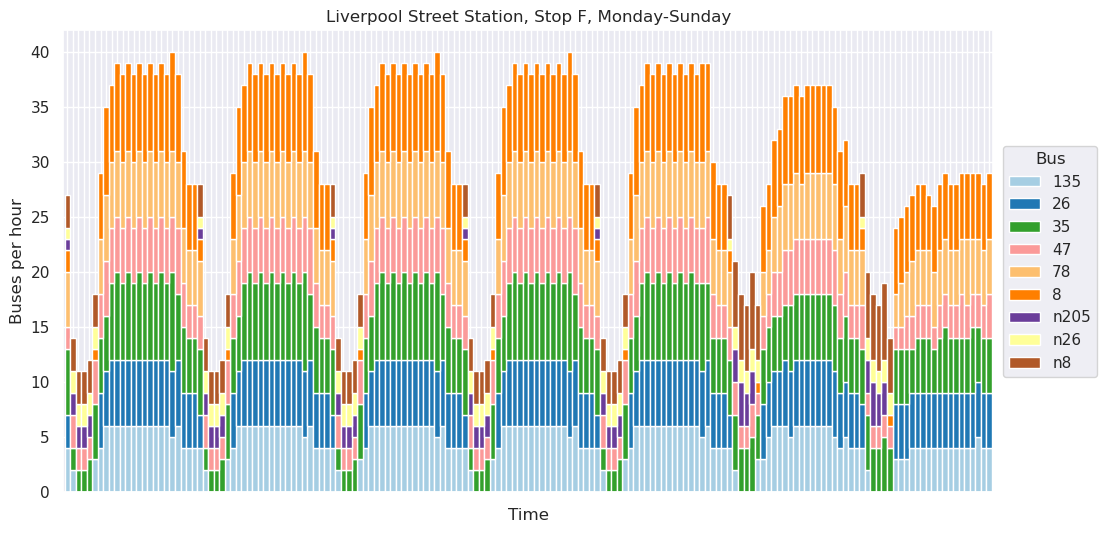

In [6]:
# An example with one bus stop and all days of the week
get_bus(['490000138F'], title='Liverpool Street Station, Stop F')

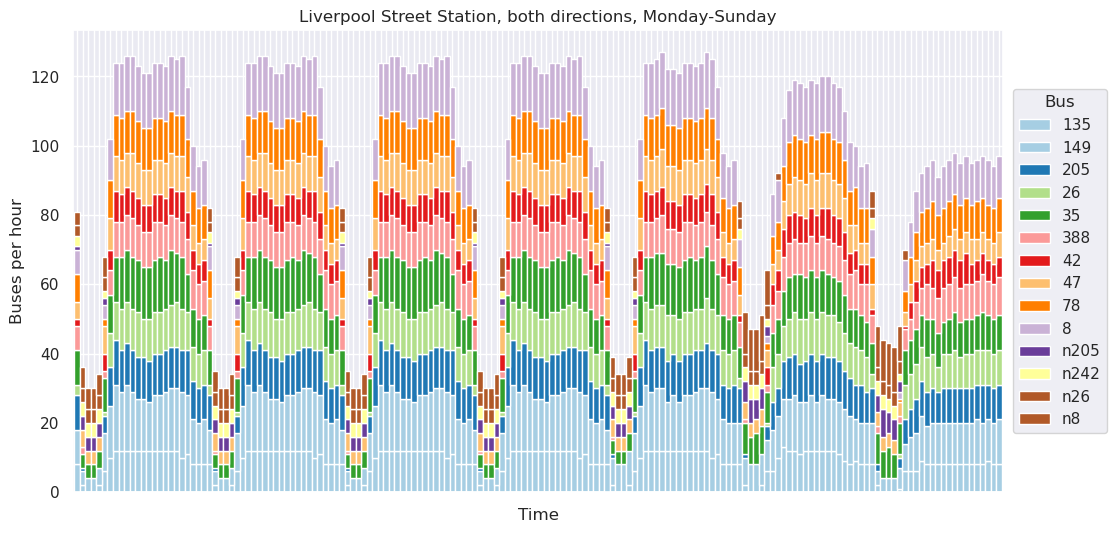

In [7]:
# An example with multiple bus stops and all days of the week
get_bus(['490000138F','490000138E', '490000138L', '490000138K'], title='Liverpool Street Station, both directions')

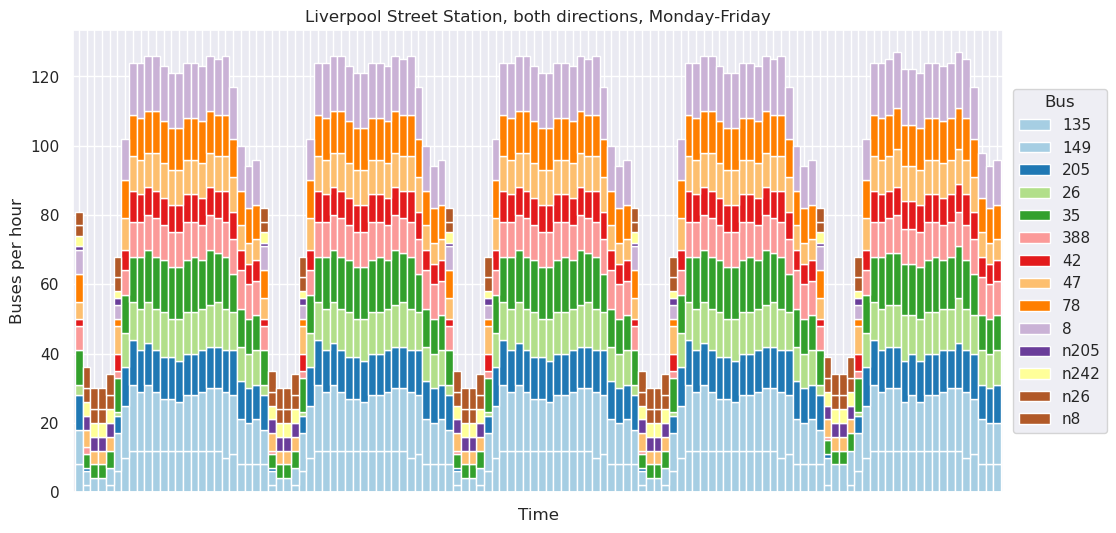

In [8]:
# An example with multiple bus stops and selected days of the week
get_bus(['490000138F','490000138E', '490000138L', '490000138K'],start_day=1, end_day=5,\
        title='Liverpool Street Station, both directions')